In [1]:
import xarray as xr
from xarray_selafin.xarray_backend import SelafinBackendEntrypoint
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import pickle

In [21]:
from scipy.spatial import cKDTree
import rasterio

In [22]:
with open('wolfCove2m_gnn_all.pkl','rb') as f:
    data = pickle.load(f)
    #labeled_trees = data['labeled_trees']
    wolfGraph = data['wolfGraph']
    # label_map = data['label_map']
    labeled_pits = data['pits_labeled']
    transform = data['transform']

In [4]:
# Open the file
ds = xr.open_dataset('3DWolfsCoveApr20.slf', engine='selafin')

# Check what we have
# print(ds)
print(f"\nDimensions: {ds.dims}")
print(f"\nVariables: {list(ds.data_vars)}")
print(f"\nCoordinates: {list(ds.coords)}")

The IPOBO array seems corrupted (zeros array). Try to rebuild it with `build_ipobo()`.



Dimensions: FrozenMappingWarningOnValuesAccess({'time': 4465, 'plan': 4, 'node': 10763})

Variables: ['Z', 'U', 'V', 'W', 'SALINITY']

Coordinates: ['x', 'y', 'time']


In [7]:
print(f"X range: {ds.x.min().values} to {ds.x.max().values}")
print(f"Y range: {ds.y.min().values} to {ds.y.max().values}")

X range: 408782.8125 to 423926.59375
Y range: 4847213.5 to 4857609.5


In [8]:
tel_node_idx0 = 878
tel_node_idx3 = tel_node_idx0 + 3*10763

In [14]:
print(labeled_pits['pit_idx'])

9768     2202198
3034      788768
9800     2206696
10810    2368779
5162     1102504
          ...   
1716      622907
1717      622908
1729      625158
1744      627408
5113     1092057
Name: pit_idx, Length: 13213, dtype: int64


In [40]:
# choose a pit from list
treePit0 = 2202198
treePit1 = 788768
treePit2 = 1102504

In [16]:
# plot to examine
# z_surface = ds.Z.isel(node=tel_node_idx0, plan=-1).values

In [17]:
# plt.plot(z_surface)

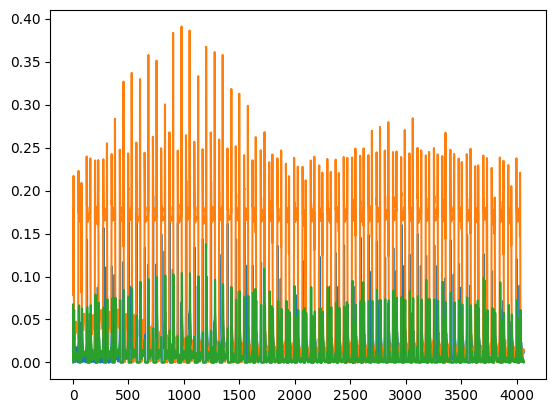

In [41]:
# with selafin imported as ds
coastPitList = [treePit0,treePit1, treePit2]
# 1. mesh coordinates
mesh_x = ds.x.values
mesh_y = ds.y.values
mesh_coords = np.column_stack([mesh_x, mesh_y])

# KD-tree for fast nearest-neighbor lookup
tree = cKDTree(mesh_coords)

# 2. for each coastal pit, find nearest telemac node
pit_velocities = {}

for pit_idx in coastPitList:
    # get pit coords (convert pixel to real-world)
    r, c = wolfGraph.nodes[pit_idx]['dem_idx']
    pit_x, pit_y = rasterio.transform.xy(transform, r, c)

    # find nearest mesh node
    dist, mesh_idx = tree.query([pit_x, pit_y])

    #print(f"pit {pit_idx}: nearest mesh node {mesh_idx}, distance {dist:.1f}m")

    # extract bottom layer (plan = 0) velocities at this node
    u_bottom = ds.U.isel(node=mesh_idx, plan=1).values # all time steps
    v_bottom = ds.V.isel(node=mesh_idx, plan=1).values

    # calculate horizontal velocity magnitude
    vel_mag = np.sqrt(u_bottom**2 + v_bottom**2)

    # summary statistics
    max_vel = np.max(vel_mag)
    mean_vel = np.mean(vel_mag)
    std_vel = np.std(vel_mag)

    # tidal range
    z_surface = ds.Z.isel(node=mesh_idx, plan=-1).values # top layer
    tidal_range = np.max(z_surface) - np.min(z_surface)

    pit_velocities[pit_idx] = {
        'max_vel': max_vel,
        'mean_vel': mean_vel,
        'std_vel': std_vel,
        'tidal_range': tidal_range,
        'mesh_node': mesh_idx,
        'dist_to_mesh': dist
    }

    # add as node attributes
    wolfGraph.nodes[pit_idx]['max_vel'] = max_vel
    wolfGraph.nodes[pit_idx]['mean_vel'] = mean_vel
    wolfGraph.nodes[pit_idx]['tidal_range'] = tidal_range

    plt.plot(vel_mag[400:])
    # plt.pl;ot(v_bottom)

In [24]:
print(pit_velocities)

{2202198: {'max_vel': np.float32(0.26882502), 'mean_vel': np.float32(0.010230401), 'std_vel': np.float32(0.0112865595), 'tidal_range': np.float32(4.2950773), 'mesh_node': 5439, 'dist_to_mesh': 8.74642784226795}}
